## Сборный проект № 4: Поиск по изображениям.

**Dataset Description:**
    
   Мы работаем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).
   
   Наши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д.
   
   Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.
   
   Наша задача разработать модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
   
   Нам также необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.
   
    
**Данные:**
    
 * `train_dataset.csv` - информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний.
 * `CrowdAnnotations.tsv` - данные по соответствию изображения и описания, полученные с помощью краудсорсинга.
 * `ExpertAnnotations.tsv` - данные по соответствию изображения и описания, полученные в результате опроса экспертов.
 * `test_queries.csv` - информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение.
 * `/train_images` - изображения для тренировки модели.
 * `/test_images` - изображения для тестирования модели.

**Цели:**

 * Разработка модели, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

**Структура проекта:**
ЗДЕСЬ БУДЕТ СОДЕРЖАНИЕ

**Предмет исследования:**

    Изображения, тестовые описания изображений, краудсорсинговые и экспертные оценки соответсвия текста и изображений.

**Методы:**
* Загрузка и ознакомление с данными
* Exploratory data analysis
* Machine learning
* Сверточные нейронные сети


**Используемые библитеки:**

* Numpy
* Pandas
* Keras
* Seaborn
* Matplotlib

In [ ]:
!jupyter notebook list

Currently running servers:
http://localhost:8888/?token=ba5faae6dcafb966db6568b5706accff46d8d9e4690516ce :: C:\Users\Daniil


### Импорт библиотек, объявление констант

In [ ]:
#!pip install WordCloud
#!pip install --upgrade WordCloud
#!pip install --upgrade pillow
#!pip install beautifulsoup4
#!pip install contractions
#!pip install catboost
#!pip install optuna
#!pip install textblob
#!pip install unidecode
#!pip install wordnet

import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
import re
import os
import wordnet
import tensorflow as tf

from PIL import Image
from os.path import exists, isfile, join
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import LinearSVR
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from unidecode import unidecode
from pathlib import Path


nltk.download('stopwords')

STOP_WORDS = set(nltk_stopwords.words('english'))
RANDOM_SEED = 12345

PATH = ''

TRAIN_PATH = 'train_images'
TEST_PATH = 'test_images'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Загрузка и ознакомление с данными

Загрузим датасеты и объявим пути к тестовым и тренировочным изображениям:

In [ ]:
train_dataset = pd.read_csv(join(PATH, 'train_dataset.csv'))
crowd_annotations = pd.read_csv(join(PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None)
expert_annotations = pd.read_csv(join(PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None)
test_queries = pd.read_csv(join(PATH, 'test_queries.csv'), sep='|', index_col=0)
test_images = pd.read_csv(join(PATH, 'test_images.csv'), sep='|')

#### train_dataset

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

Взглянем на общую информацию:

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В нашем распоряжении 5822 строки, без пропусков.

In [ ]:
train_dataset.head()

image                     query_id   
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  \
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Данные соответсвуют описанию.

In [ ]:
train_dataset.describe()

image                     query_id   
count                        5822                         5822  \
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

В тренировочном датасете мы имеем 1000 изображений, имеющих 5822 описаний, причем только 977 описаний уникальны.

Взглянем на несколько фотографий и описаний:

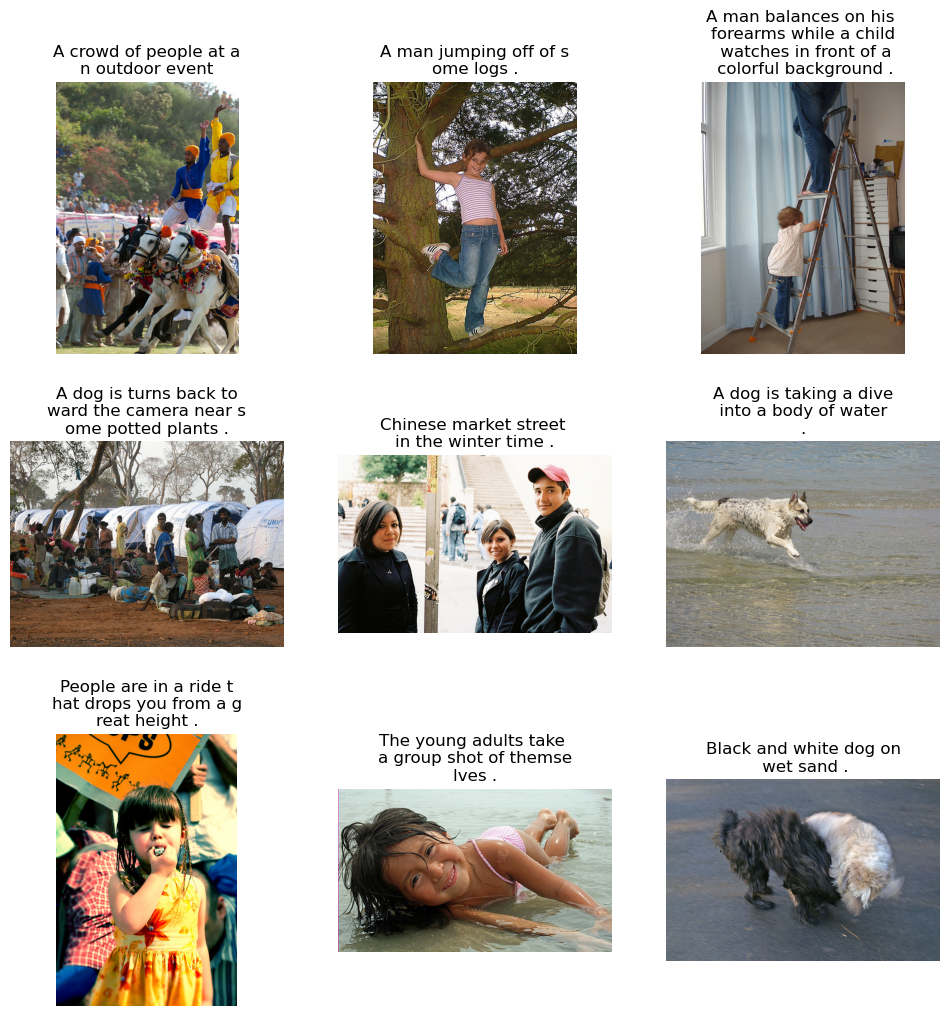

In [ ]:
rows = 3
columns = 3

fig = plt.figure(figsize=(12, 12))
count = 1
for _, file, _, query_text in train_dataset.sample(rows * columns, random_state=RANDOM_SEED).itertuples():
    img = Image.open(os.path.join(PATH,  'train_images', file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis('off')
    chunks, chunk_size = len(query_text), 22
    plt.title('\n'.join([query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

На первый взгляд, в разметки данных есть ошибки.

#### crowd_annotations

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

Взглянем на общую информацию:

In [ ]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Имеем 47830 строк без пропусков.

In [ ]:
crowd_annotations.head()

0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3

#### expert_annotations

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.
3. 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

In [ ]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [ ]:
expert_annotations.head()

0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2

#### test_queries

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

Взглянем на общую информацию:

In [ ]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В нашем распоряжении 500 строк, без пропусков.

In [ ]:
test_queries.head()

query_id   
0  1177994172_10d143cb8d.jpg#0  \
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text   
0  Two blonde boys , one in a camouflage shirt an...  \
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
test_queries.describe()

query_id   
count                           500  \
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text   
count                                                 500  \
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

В тестовом датасете 100 фото с 500 описаниями, т.е. в среднем одной фотографии соответсвует около 5 описаний.

### Подготовка данных

#### People annotations

В начале этапа подготовки данных, проверим соответсвие доли положительно проголосовавших при провежении краудсорсинга:

In [ ]:
def check(row):
    return math.isclose(row[2], row[3]/(row[3] + row[4]))

crowd_annotations['check'] = crowd_annotations.apply(check, axis=1)
crowd_annotations[crowd_annotations['check'] == False]

Empty DataFrame
Columns: [0, 1, 2, 3, 4, check]
Index: []

Доля высчитана верно.

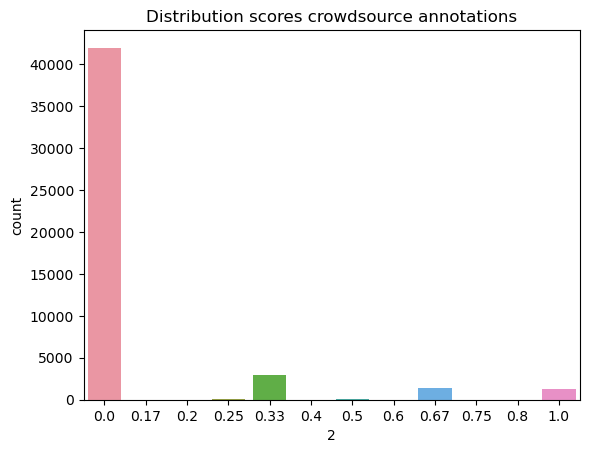

In [ ]:
crowd_annotations = crowd_annotations.loc[:, [0, 1, 2]]
sns.countplot(x=round(crowd_annotations[2], 2)).set_title('Distribution scores crowdsource annotations');

Большинство голосовавших людей считают что описание не соответсвует изображению.

Нормализуем оценки людей в диапазоне от 0 до 1:

In [ ]:
crowd_annotations[2].head(10)

0    1.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.333333
8    0.000000
9    0.000000
Name: 2, dtype: float64

#### Expert annotations

Посмотрим как обстоят дела с экспертами:

In [ ]:
def score_norm(row):
    row_list = []
    column_list = [2, 3, 4]
    for column_num in column_list:
        row_list.append(str(row[column_num]))
    return ''.join(sorted(row_list))

expert_annotations['row_list'] = expert_annotations.apply(score_norm, axis=1)
expert_annotations.head()

0                            1  2  3  4 row_list
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1      111
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2      112
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2      112
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2      122
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2      112

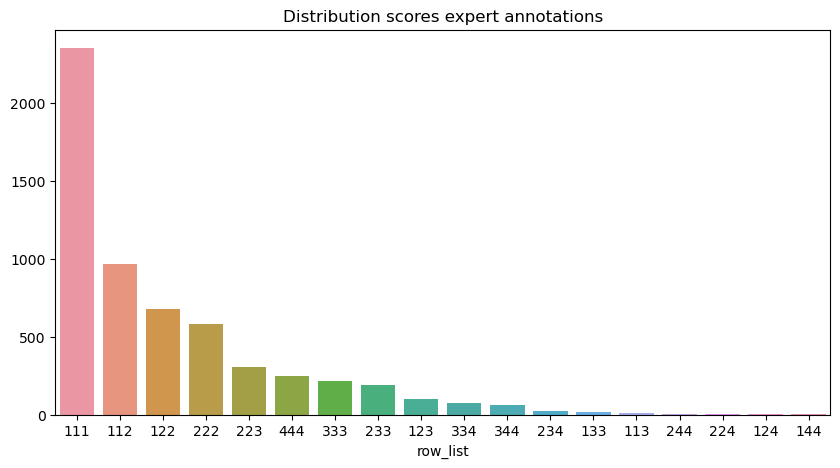

In [ ]:
plt.figure(figsize=(10,5))
expert = expert_annotations['row_list'].value_counts()
sns.barplot(x=expert.index, y=expert.values).set_title('Distribution scores expert annotations');

Большинство экспертов считают что описания не соответсвуют изображениям.

In [ ]:
expert_annotations = expert_annotations.drop('row_list', axis=1)

Нормализуем оценки экспертов:
* Если эксперты не пришли к единому мнению - None.
* Если все оценки одинаковые - оценка разделенная на максимальный балл.
* В остальных случаях смотрим на мнение большинства и делим оценку большинства на макисмальный балл.

In [ ]:
def expert_norm(row):
    row_list = []
    column_list = [2, 3, 4]
    x = row[2]
    y = row[3]
    z = row[4]

    if (x == y == z):
        return (x - 1) / 3
    elif (x == y):
        return (x - 1) / 3
    elif x == z:
        return (x - 1) / 3
    elif y == z:
        return (y - 1) / 3
    else:
        return None

expert_annotations['expert_score'] = round(expert_annotations.apply(expert_norm, axis=1), 2)
expert_annotations.head()

0                            1  2  3  4   
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1  \
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1  2  2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1  1  2   

   expert_score  
0          0.00  
1          0.00  
2          0.00  
3          0.33  
4          0.00

Удалим записи в которых эксперты не пришли к единому мнению:

In [ ]:
print(f'Размер датасета до удаления: {len(expert_annotations)}')
expert_annotations = expert_annotations.dropna()
print(f'Размер датасета после удаления: {len(expert_annotations)} строк')

Размер датасета до удаления: 5822
Размер датасета после удаления: 5696 строк


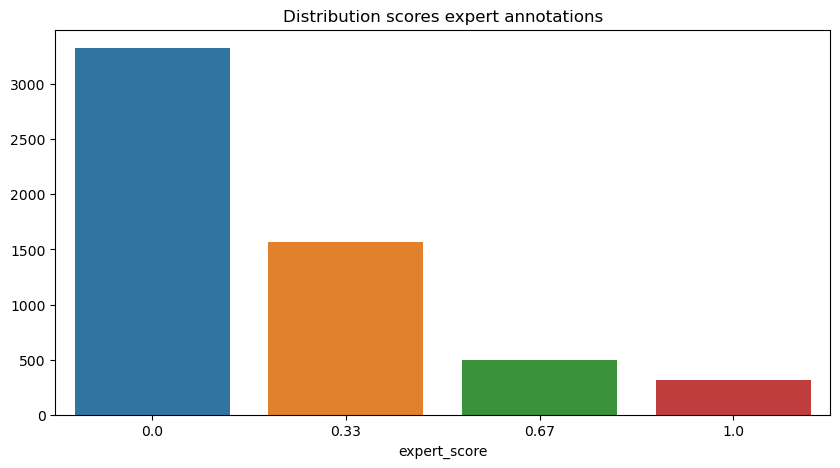

In [ ]:
plt.figure(figsize=(10,5))
expert = expert_annotations['expert_score'].value_counts()
sns.barplot(x=expert.index, y=expert.values).set_title('Distribution scores expert annotations');

In [ ]:
expert_annotations = expert_annotations[[0, 1, 'expert_score']]

#### Summary score

Объединим оценки экспертов и людей с тренировочным датасетом:

In [ ]:
expert_annotations.columns = ['image', 'query_id', 'expert_score']
crowd_annotations.columns = ['image', 'query_id', 'crowd_score']

In [ ]:
train_dataset = train_dataset.merge(expert_annotations, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='outer')
train_dataset = train_dataset.merge(crowd_annotations, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='outer')
train_dataset = train_dataset.reset_index(drop=True)

Создадим датасет с текстами:

In [ ]:
notna_train = train_dataset[train_dataset['query_text'].notna()][['query_id', 'query_text']]
notna_train.head()

query_id   
0  2549968784_39bfbe44f9.jpg#2  \
1  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg#2   
4  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Заполним пропущенные текстовые описания в тренировочном датасете

In [ ]:
notna_train.dtypes

query_id      object
query_text    object
dtype: object

In [ ]:
train_dataset[['query_id', 'query_text']].dtypes

query_id      object
query_text    object
dtype: object

In [ ]:
def fillna_text(row):

    if pd.isnull(row['query_text']):
        text = notna_train[notna_train['query_id'] == row['query_id']]['query_text']
        if len(text) != 0:
            row['query_text'] = text.iloc[0]
    return row

train_dataset = train_dataset.apply(fillna_text, axis=1)

Агрегируем оценки простых людей и экспертов:

In [ ]:
train_dataset = train_dataset.dropna(subset=['query_text'])
train_dataset = train_dataset[((train_dataset['expert_score'].notna() | train_dataset['crowd_score'].notna())
                   & (train_dataset['expert_score'].notna() | train_dataset['crowd_score'].notna()))]
train_dataset = train_dataset.fillna(0)

def expert_norm(row):

    if math.isnan(row['expert_score'])==False and math.isnan(row['crowd_score'])==False:
        return row['expert_score'] * 0.6 + row['crowd_score'] * 0.4
    elif math.isnan(row['expert_score'])==True:
        return row['crowd_score']
    elif math.isnan(row['crowd_score'])==True:
        return row['expert_score']
    else:
        return None

train_dataset['final_score'] = train_dataset.apply(expert_norm, axis=1)
train_dataset = train_dataset[train_dataset['final_score'].notna()]
train_dataset = train_dataset[['image', 'query_id', 'query_text', 'final_score']]

train_dataset.head()

image                     query_id   
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  \
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  
0  A young child is wearing blue goggles and sitt...        0.000  
1  A young child is wearing blue goggles and sitt...        0.000  
2  A young child is wearing blue goggles and sitt...        0.198  
3  A young child is wearing blue goggles and sitt...        1.000  
4  A young child is wearing blue goggles and sitt...        0.000

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50159 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50159 non-null  object 
 1   query_id     50159 non-null  object 
 2   query_text   50159 non-null  object 
 3   final_score  50159 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


В итоге имее 50000 запросов и описаний:

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50159 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50159 non-null  object 
 1   query_id     50159 non-null  object 
 2   query_text   50159 non-null  object 
 3   final_score  50159 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


#### Lemmatization

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Взглянем какие слова часто встречаются в описаниях:

CPU times: total: 0 ns
Wall time: 0 ns


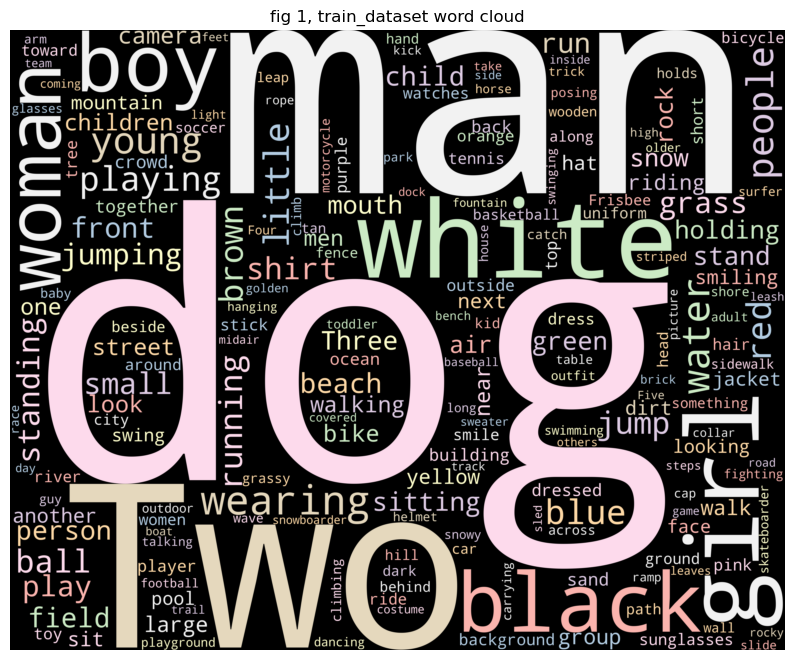

In [ ]:
%time

text = train_dataset
# Извлечение текста
text = " ".join(x for x in text.query_text)
# Создание WordCloud
word_cloud = WordCloud(
    width=5000,
    height=4000,
    random_state=1,
    background_color='black',
    colormap='Pastel1',
    collocations=False,
    stopwords=STOP_WORDS,
).generate(text)
# Отрисовка
plt.figure(figsize=(10,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('fig 1, train_dataset word cloud')
plt.show()

Создадим конвеер лемматизации:

In [ ]:
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
    words = text.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    words = [w for w in words if len(w) > 2]
    return ' '.join(words)

In [ ]:
class TextPreoprocessingSteps:
    def __init__(self, X):
        self.X = X
        self.remove_punctuations = string.punctuation.replace('.', '')

    def to_lower(self):
        self.X = self.X.apply(lambda x: x.lower())
        return self

    def remove_html_tags(self):
        def process_html(x):
            if isinstance(x, str) and "<" in x and ">" in x:
                return BeautifulSoup(x, "html.parser").get_text()
            return x

        self.X = self.X.apply(process_html)
        return self

    def replace_diacritics(self):
        self.X = self.X.apply(lambda x: unidecode(x, errors="preserve"))
        return self

    def expand_contractions(self):
        self.X = self.X.apply(lambda x: " ".join(
            [contractions.fix(expanded_word) for expanded_word in x.split()]))
        return self

    def remove_numbers(self):
        self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
        return self

    def remove_punctuations_except_periods(self):
        self.X = self.X.apply(lambda x: re.sub(
            '[%s]' % re.escape(self.remove_punctuations), '', x))
        return self

    def remove_all_punctuations(self):
        self.X = self.X.apply(lambda x: re.sub(
            '[%s]' % re.escape(string.punctuation), '', x))
        return self

    def replace_dots_with_spaces(self):
        self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
        return self

    def remove_double_spaces(self):
        self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
        return self

    def fix_typos(self):
        self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
        return self

    def remove_stopwords(self):
        self.X = self.X.apply(lambda x: " ".join(
            [word for word in x.split() if word not in STOP_WORDS]))
        return self

    def lemmatize(self):

        self.X = self.X.apply(lambda x: lemmatize_text(x))
        return self

    def get_processed_text(self):
        return self.X

In [ ]:
class TextPreoprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        txt_preproc = TextPreoprocessingSteps(X.copy())
        processed_text = \
            txt_preproc \
            .to_lower()\
            .remove_all_punctuations()\
            .replace_diacritics()\
            .remove_html_tags()\
            .remove_numbers()\
            .remove_double_spaces()\
            .lemmatize()\
            .remove_stopwords()\
            .get_processed_text()

        return processed_text

In [ ]:
pure_transformation_pipeline = Pipeline(steps=[
           ('text_preproc', TextPreoprocessor())])

Проводим лемматизацию текстов:

In [ ]:
%time

train_dataset['query_text'] = pure_transformation_pipeline.fit_transform(train_dataset['query_text'])

#### Удаление проблемного контента

Создадим список запрещенных слов:

In [ ]:
ban_words = ['girl', 'young', 'child', 'boy', 'baby',
             'children', 'teenager', 'schoolboy',
             'school girl', 'kid', 'youth', 'newborn',
            'babe', 'infant', 'teeny', 'juvenile', 'teener',
            'stripling']

Поставим флаг "banned" для строк содержащих запрещенную информацию:

In [ ]:
train_dataset['banned'] = train_dataset['query_text'].apply(
    lambda x: True if len(set(ban_words).intersection(x.split(' '))) >= 1 else None)
train_dataset['banned'] = train_dataset['banned'].fillna(False)

Проверим:

In [ ]:
print(train_dataset[train_dataset['banned'] == 1]['query_text'].sample(10).unique())

['two child play spray water' 'young longhaired girl beach jumping air'
 'two girl pajama pant appear dance' 'little boy helmet trick skateboard'
 'little girl piece playground equipment'
 'two little girl dress pink play jungle gym' 'girl wear green dress'
 'two child play ball grass' 'girl stand girl glass work hand painting'
 'two baby sit close together reach something']


Отфильтруем датасет:

In [ ]:
print(f'Размер датасета до удаления запрещенного контента {len(train_dataset)}')
train_dataset = train_dataset[train_dataset['banned'] == False]
print(f'Размер датасета после удаления запрещенного контента {len(train_dataset)}')
train_dataset = train_dataset.reset_index(drop=True)

Размер датасета до удаления запрещенного контента 50159
Размер датасета после удаления запрещенного контента 35441


#### Text vectorizing

Векторизацию будем проводить при помощи TfidfVectorizer:

In [ ]:
vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))

In [ ]:
train_df_vect = vectorizer.fit_transform(train_dataset.query_text)

In [ ]:
text_vect_size = train_df_vect.shape[1]

#### Image vectorizing

Создадим дата-генератор для загрузки фотографий:

Found 35441 validated image filenames.


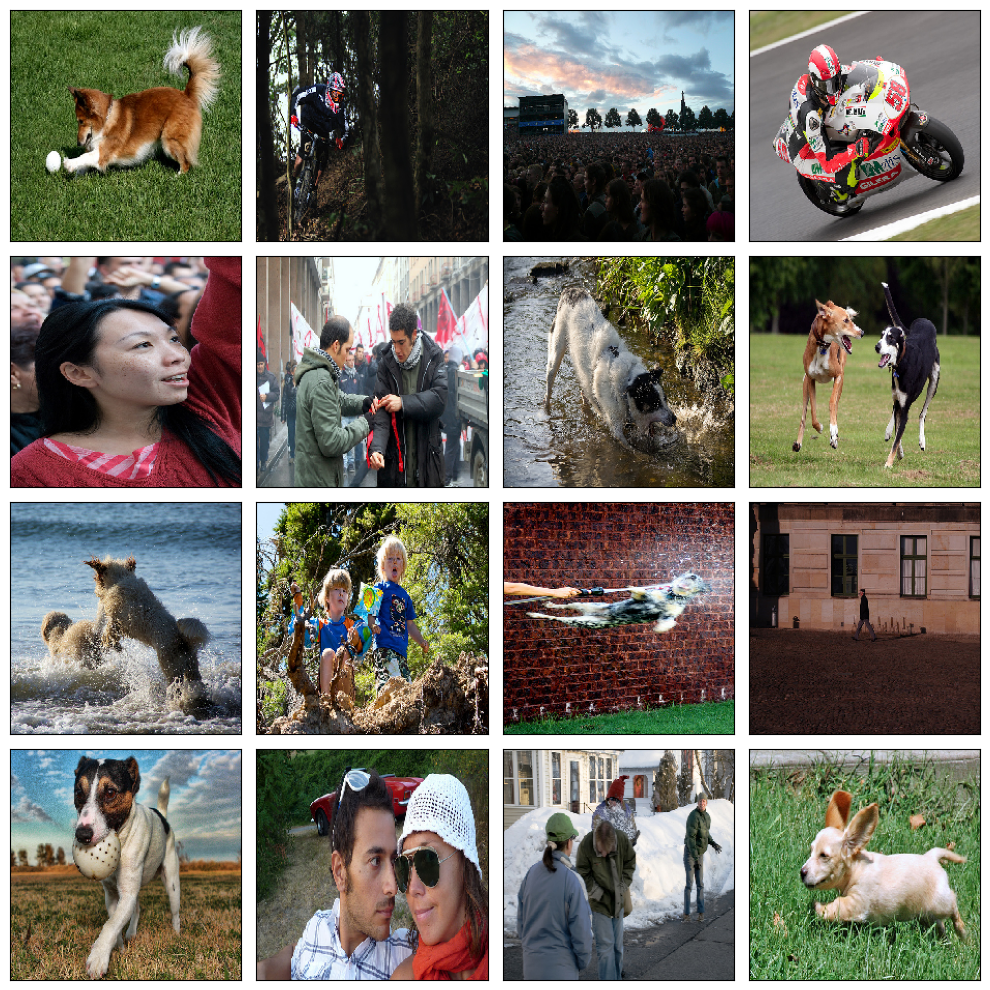

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=os.path.join(PATH, TRAIN_PATH),
        x_col='image',
        y_col='final_score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_SEED)

features, target = train_gen_flow.next()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Векторизацию изображений будем производить при помощи предобученной модели ResNet50:

In [ ]:
def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
def image_vectorization(model, train_data):
    predictions = model.predict(train_data)
    return predictions

Производим векторизацию изображений:

In [ ]:
%time

image_embedings = image_vectorization(create_model(), train_gen_flow)
image_embedings.shape

CPU times: total: 0 ns
Wall time: 0 ns
2216/2216 [==============================] - 651s 293ms/step


(35441, 2048)

#### Объединение векторов

In [ ]:
image_embedings.shape

(35441, 2048)

In [ ]:
train_df_vect.toarray().shape

(35441, 936)

In [ ]:
features = np.concatenate((image_embedings, train_df_vect.toarray()), axis=1)
features.shape

(35441, 2984)

In [ ]:
y = np.array(train_dataset['final_score'])
y.shape

(35441,)

#### Вывод на этапе подготовки данных

* На этапе подготовки данных мы Стандартизировали оценки экспертов и простых людей, затем мы объединили их в общую оценку.
* Большинство оценок простых людей и экспертов сообщают нам что описание не подходит под изображение.
* Также на данном этапе мы объеденили оценки и текстовые описания, обработали пропуски в данных.
* Очистили данные от запрещеного контента.
* Провели лемматизацию текстов.
* Перевели в векторное представление изображение и тексты, получили вектора размерностей: (35441, 2048) и (35441, 936), а затем объеденили их вединый вектор произнаков.

### Train/test split

Т.к. нам важно чтобы обучаюшие изображения не попали в тестовую выборку будем использовать GroupShuffleSplit, размер тестовой выборки 0.2, а также производим стандартизацию векторов:

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_SEED)
train_indices, test_indices = next(gss.split(X=features, y=y, groups=train_dataset['image']))

In [ ]:
X_train, X_test = features[train_indices], features[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Learning model

На этапе обучения моделей используем: LinearRegression, LinearSVR и NeuralNetwork.

MAPE, MAE и RMSE подходят под нашу задачу но:

* MAPE является хорошей метрикой близости, но когда цели близки к нулю -  может давать завышенные результаты

* RMSE будет активно реагировать на  выбросы.

В качестве основной метрики будем использовать RMSE.

#### Ridge

In [ ]:
from sklearn.linear_model import Ridge

model_lr = Ridge(alpha=1.0).fit(X_train, y_train)
predictions = model_lr.predict(X_test)
mean_squared_error(y_test, predictions)

0.01449411925113974

In [ ]:
pred = model_lr.predict(X_test)
mean_squared_error(y_test, pred, squared=False).round(decimals=3)

0.12

#### LinearSVR

In [ ]:
model = LinearSVR(random_state=RANDOM_SEED)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_SEED),
    verbose=1
)

In [ ]:
%time
gs_svr.fit(X_train, y_train, groups=train_dataset['image'].loc[train_indices])

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\Daniil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=GroupShuffleSplit(n_splits=3, random_state=12345, test_size=None,
         train_size=None),
             estimator=LinearSVR(random_state=12345), n_jobs=-1,
             param_grid={'C': [1], 'loss': ['squared_epsilon_insensitive']},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
pd.DataFrame(gs_svr.cv_results_)[['param_C', 'param_loss', 'mean_test_score', 'rank_test_score']].round(decimals=3)

param_C                   param_loss  mean_test_score  rank_test_score
0       1  squared_epsilon_insensitive           -0.157                1

In [ ]:
pred = gs_svr.predict(X_test)
mean_squared_error(y_test, pred).round(decimals=3)

0.021

#### NeuralNetwork

In [ ]:
NN = Sequential()
NN.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(128, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               764160    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)             

In [ ]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=5,
    verbose=2, shuffle=True
    )

Epoch 1/5
887/887 - 9s - loss: 0.3537 - root_mean_squared_error: 0.5948 - val_loss: 0.1775 - val_root_mean_squared_error: 0.4213 - 9s/epoch - 11ms/step
Epoch 2/5
887/887 - 5s - loss: 0.1550 - root_mean_squared_error: 0.3937 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3077 - 5s/epoch - 6ms/step
Epoch 3/5
887/887 - 6s - loss: 0.0955 - root_mean_squared_error: 0.3091 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2505 - 6s/epoch - 7ms/step
Epoch 4/5
887/887 - 7s - loss: 0.0647 - root_mean_squared_error: 0.2544 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2087 - 7s/epoch - 8ms/step
Epoch 5/5
887/887 - 6s - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814 - 6s/epoch - 6ms/step


In [ ]:
mean_squared_error(y_test, NN.predict(X_test)).round(decimals=3)

222/222 [==============================] - 0s 2ms/step


0.033

#### Вывод на этапе обучения моделей

На этапе обучения моделей мы обучили модели LinearRegression, LinearSVR и NeuralNetwork, в качесте целевой метрики мы использовали mean_squared_error, наилучший результат на данном этапе показала модель NeuralNetwork.

### Final testing

На этапе финального тестирования создаем тестовый дата_генератор и объявляем функцию принимающую на вход текст запроса, на вход обученной модели подаем суммарный вектор сотоящий из тестовых изображений и текста запроса, получая предсказания - выделим топ5 предсказаний с самой высокой оценкой модели по части совпадения описания и текста запроса, в случае если текстовый запрос содержит запрещенные слова - выводим дислаймер.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_images,
        directory=TEST_PATH,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_SEED)

features, target = test_gen_flow.next()


test_image_embedings = image_vectorization(create_model(), test_gen_flow)
test_image_embedings.shape

Found 100 validated image filenames.
7/7 [==============================] - 3s 273ms/step


(100, 2048)

In [ ]:
def get_picture(text):

    temp_data = pd.DataFrame()
    temp_data.loc[0, 'text'] = text
    temp_data

    temp_data['text'] = pure_transformation_pipeline.fit_transform(temp_data['text'])

    temp_data['banned'] = temp_data['text'].apply(lambda x: True if len(set(ban_words).intersection(x.split(' '))) >= 1 else None)

    if temp_data.loc[0, 'banned'] == True:
        print('This image is unavailable in your country in compliance with local laws.')
    else:

        test_text_embed = (vectorizer.transform(temp_data['text'])).toarray()
        X = np.concatenate(( #объединяем вектора тестовых картинок с эмбеддингом текста
            test_image_embedings,
            np.resize(test_text_embed, (test_image_embedings.shape[0], text_vect_size))),
            axis=1)
        X = scaler.transform(X)
        predictions = NN.predict(X) #получаем предсказания оценок экспертов
        df = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) #получили топ 5 имён файлов с картинками
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) #получили топ 5 оценок
        print('')
        print('-' * 20, text, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 5))
            image = Image.open(join(TEST_PATH, top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(test_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(TEST_PATH, test_queries.iloc[test_queries[test_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

In [ ]:
samples = test_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A large bird spreading his wings in flight over a body of water .',
 'A watercraft speeds through the water .',
 'Two young girls on a playground .',
 'A boy wearing blue shorts is bouncing a basketball in front of the net .',
 'A dog is jumping into a pool for a swim competition',
 'a tan dog wearing a multicolored color running on the beach',
 'One person in a crowd of people , wearing a blue wig',
 'Two dogs are wrestling in a field .',
 'a large group of young people all dressed in white tops and green bottoms',
 'Two girls in pink are playing on yellow playground bars .']

4/4 [==============================] - 0s 2ms/step

-------------------- A large bird spreading his wings in flight over a body of water . --------------------



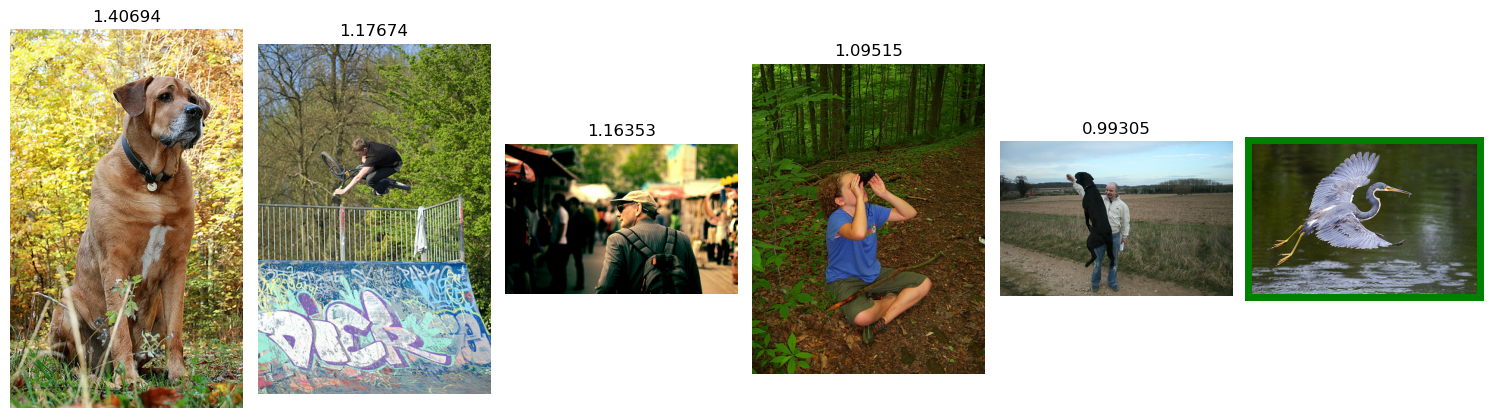

4/4 [==============================] - 0s 3ms/step

-------------------- A watercraft speeds through the water . --------------------



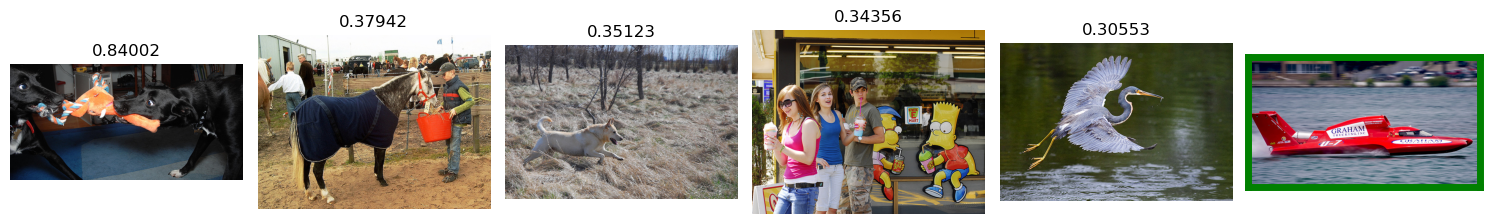

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.
4/4 [==============================] - 0s 3ms/step

-------------------- A dog is jumping into a pool for a swim competition --------------------



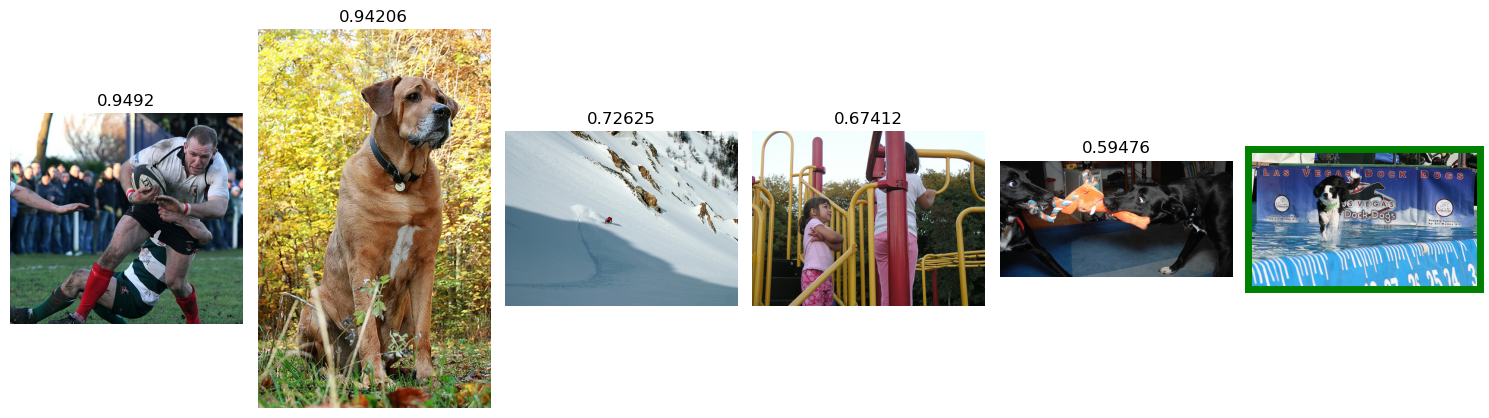

4/4 [==============================] - 0s 2ms/step

-------------------- a tan dog wearing a multicolored color running on the beach --------------------



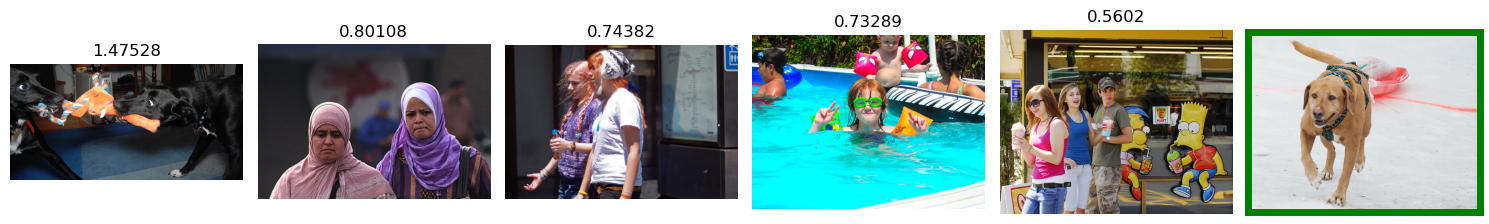

4/4 [==============================] - 0s 2ms/step

-------------------- One person in a crowd of people , wearing a blue wig --------------------



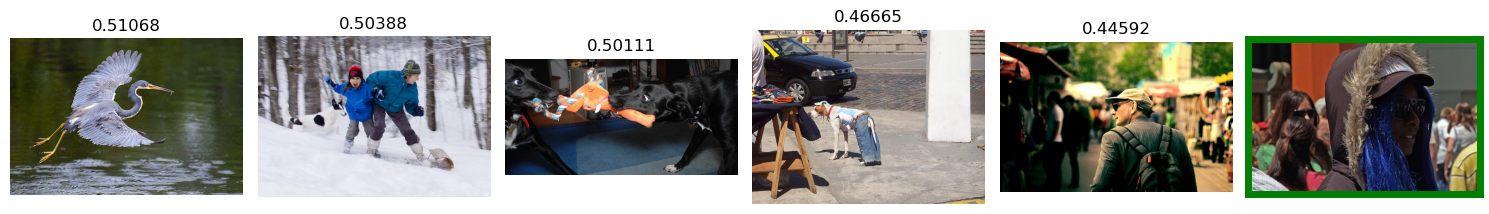

4/4 [==============================] - 0s 2ms/step

-------------------- Two dogs are wrestling in a field . --------------------



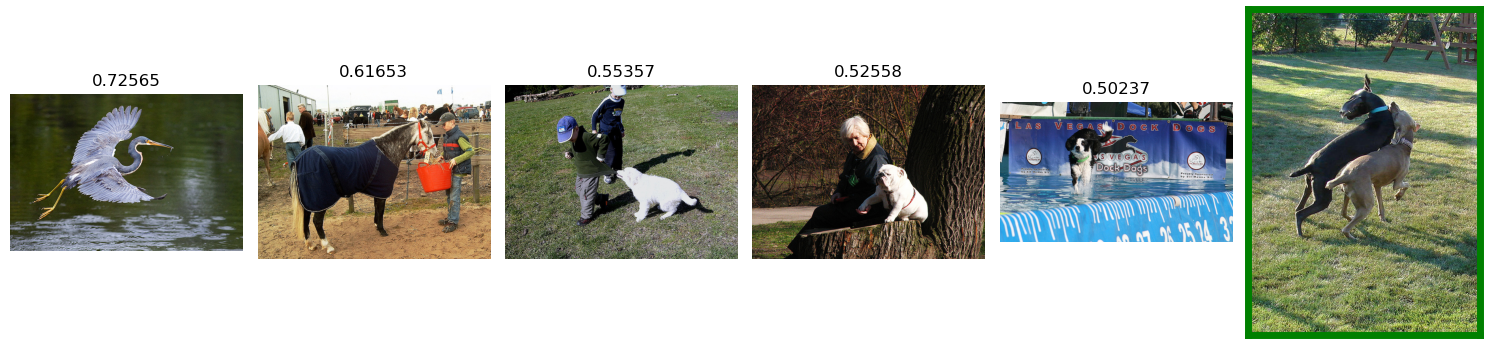

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [ ]:
for text in text_test:
    get_picture(text)

### Общий вывод

В рамках данного проекта мы:
* Произвели загрузку и ознакомление с данными.
* Агрегировали оценки экспертов и простых людей и объединили их в общую оценку, а затем соединили с текстовыми описаниями.
* Избавились от запрещенного контента
* Обработали тексты, перевели тексты и изображения в векторное пространство
* Разделили данные на третировочную и валидационные выборки
* Произвели тестирвание нескольких моделей (LinearRegression, LinearSVR и NeuralNetwork).
* Произвели финальное тестирование модели NeuralNetwork

К сожалению получить работоспособную модель в данном проекте мне не удалось, предположу что это связанно с малой долей описаний подходящих под изображения как со стороны экспертов, так и со стороны простых людей. В качестве альтернативного варианта для решения поставленной задачи можно использовать предобученные модели.